# 텍스트 분류와 ML VS DL
- 텍스트 분류 리뷰: 수집된 뉴스 데이터 분야 분류
- ML 기법
- DL 활용 

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 37.5 MB/s 
     |████████████████████████████████| 448 kB 43.7 MB/s 


# 텍스트 처리 
- text 폴더 생성 후, 100, 101, 103, 105 폴더 생성
- 각 폴더에 150개의 기사들을 각각 업로드

In [ ]:
# TF-IDF로 텍스트를 벡터로 변환하는 모듈
from konlpy.tag import Okt
import pickle
import numpy as np

# KoNLPy의 Okt객체 초기화 ---- ( ※ 1)
okt = Okt()
# 전역 변수 --- ( ※ 2)
word_dic = {'_id': 0} # 단어 사전
dt_dic = {} # 문장 전체에서의 단어 출현 횟수
files = [] # 문서들을 저장할 리스트

def tokenize(text):
    '''KoNLPy로 형태소 분석하기''' # --- ( ※ 3) 
    result = []
    word_s = okt.pos(text, norm=True, stem=True)
    for n, h in word_s:
        if not (h in ['Noun', 'Verb ', 'Adjective']): continue
        if h == 'Punctuation' and h2 == 'Number': continue
        result.append(n)
    return result

def words_to_ids(words, auto_add = True):
    ''' 단어를 ID로 변환하기 ''' # --- ( ※ 4)
    result = []
    for w in words:
        if w in word_dic:
            result.append(word_dic[w])
            continue
        elif auto_add:
            id = word_dic[w] = word_dic['_id']
            word_dic['_id'] += 1
            result.append(id)
    return result

def add_text(text):
    '''텍스트를 ID 리스트로 변환해서 추가하기''' # --- (*5)
    ids = words_to_ids(tokenize(text))
    files.append(ids)

def add_file(path):
    '''텍스트 파일을 학습 전용으로 추가하기''' # --- (*6)
    with open(path, "r", encoding="utf-8") as f:
        s = f.read()
        add_text(s)

def calc_files():
    '''추가한 파일 계산하기''' # --- (*7)
    global dt_dic
    result = []
    doc_count = len(files)
    dt_dic = {}
    # 단어 출현 횟수 세기 --- (*8)
    for words in files:
        used_word = {}
        data = np.zeros(word_dic['_id'])
        for id in words:
            data[id] += 1
            used_word[id] = 1
        # 단어 t가 사용되고 있을 경우 dt_dic의 수를 1 더하기 --- (*9)
        for id in used_word:
            if not(id in dt_dic): dt_dic[id] = 0
            dt_dic[id] += 1
        # 정규화하기 --- (*10)
        data = data / len(words) 
        result.append(data)
    # TF-IDF 계산하기 --- (*11)
    for i, doc in enumerate(result):
        for id, v in enumerate(doc):
            idf = np.log(doc_count / dt_dic[id]) + 1
            doc[id] = min([doc[id] * idf, 1.0])
        result[i] = doc
    return result

def save_dic(fname):
    '''사전을 파일로 저장하기''' # --- (*12)
    pickle.dump(
        [word_dic, dt_dic, files],
        open(fname, "wb"))

def load_dic(fname):
    '''사전 파일 읽어 들이기''' # --- (*13)
    global word_dic, dt_dic, files
    n = pickle.load(open(fname, 'rb'))
    word_dic, dt_dic, files = n

def calc_text(text):
    ''' 문장을 벡터로 변환하기 ''' # --- ( ※ 14)
    data = np.zeros(word_dic['_id'])
    words = words_to_ids(tokenize(text), False)
    for w in words:
        data[w] += 1
    data = data / len(words)
    for id, v in enumerate(data):
        idf = np.log(len(files) / dt_dic[id]) + 1
        data[id] = min([data[id] * idf, 1.0])
    return data
# 모듈 테스트하기 --- ( ※ 15)
if __name__ == '__main__':
    add_text('비')
    add_text('오늘은 비가 내렸어요.') 
    add_text('오늘은 더웠지만 오후부터 비가 내렸다.') 
    add_text('비가 내리는 일요일이다.') 
    print(calc_files())
    print(word_dic)

[array([1., 0., 0., 0., 0.]), array([0.5       , 0.84657359, 0.        , 0.        , 0.        ]), array([0.25      , 0.4232868 , 0.59657359, 0.59657359, 0.        ]), array([0.5, 0. , 0. , 0. , 1. ])]
{'_id': 5, '비': 0, '오늘': 1, '덥다': 2, '오후': 3, '일요일': 4}


# pickle을 통한 저장

In [ ]:
import os, glob, pickle
#import tfidf

# 변수 초기화
y = []
x = []

# 디렉터리 내부의 파일 목록 전체에 대해 처리하기 --- (*1)
def read_files(path, label):
    print("read_files=", path)
    files = glob.glob(path + "/*.txt")
    for f in files:
        if os.path.basename(f) == 'LICENSE.txt': continue
        add_file(f)
        y.append(label)

# 기사를 넣은 디렉터리 읽어 들이기 --- ( ※ 2)
read_files('text/100', 0)
read_files('text/101', 1)
read_files('text/103', 2)
read_files('text/105', 3)


# TF-IDF 벡터로 변환하기 --- (*3)
x = calc_files()

# 저장하기 --- (*4)
pickle.dump([y, x], open('text/genre.pickle', 'wb'))
save_dic('text/genre-tdidf.dic')
print('ok')


read_files= text/100
read_files= text/101
read_files= text/103
read_files= text/105
ok


In [ ]:
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np

# TF-IDF 데이터베이스 읽어 들이기 --- (*1)
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0][0:600] # 레이블
x = data[1][0:600] # TF-IDF


In [ ]:
# 학습 전용과 테스트 전용으로 구분하기 --- (*2)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2)

# 나이브 베이즈로 학습하기 --- (*3)
model = GaussianNB()
model.fit(x_train, y_train)

# 평가하고 결과 출력하기 --- (*4)
y_pred = model.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
rep = metrics.classification_report(y_test, y_pred)

print("정답률=", acc)
print(rep)




정답률= 0.7916666666666666
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.77      0.79      0.78        29
           2       0.76      0.76      0.76        29
           3       0.75      0.83      0.79        29

    accuracy                           0.79       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.80      0.79      0.79       120



# DL로 분류

Epoch 1/5
4/4 [==============================] - 3s 505ms/step - loss: 1.3607 - accuracy: 0.4271 - val_loss: 1.2318 - val_accuracy: 0.7917
Epoch 2/5
4/4 [==============================] - 1s 170ms/step - loss: 1.0182 - accuracy: 0.9000 - val_loss: 0.8291 - val_accuracy: 0.8333
Epoch 3/5
4/4 [==============================] - 1s 167ms/step - loss: 0.4892 - accuracy: 0.9458 - val_loss: 0.5749 - val_accuracy: 0.8500
Epoch 4/5
4/4 [==============================] - 1s 170ms/step - loss: 0.2067 - accuracy: 0.9833 - val_loss: 0.5087 - val_accuracy: 0.8500
Epoch 5/5
4/4 [==============================] - 0s 21ms/step - loss: 0.4941 - accuracy: 0.8500
정답률= 0.8500000238418579 loss= 0.49408596754074097


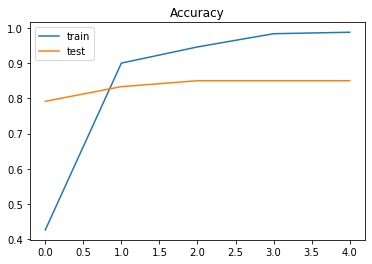

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import h5py

# 분류할 레이블 수 --- (*1)
nb_classes = 4

# 데이터베이스 읽어 들이기 --- (*2)
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0][0:600] # 레이블
x = data[1][0:600] # TF-IDF
# 레이블 데이터를 One-hot 형식으로 변환하기 --- (*3)
y = tf.keras.utils.to_categorical(y, nb_classes)
in_size = x[0].shape[0]

# 학습 전용과 테스트 전용으로 구분하기 --- (*4)
x_train, x_test, y_train, y_test = train_test_split(
        np.array(x), np.array(y), test_size=0.2)

# MLP모델의 구조 정의하기 --- (*5)
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

# 모델 컴파일하기 --- (*6)
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# 학습 실행하기 --- (*7)
hist = model.fit(x_train, y_train,
          batch_size=128, 
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

# 평가하기 ---(*8)
score = model.evaluate(x_test, y_test, verbose=1)
print("정답률=", score[1], 'loss=', score[0])

# 가중치데이터 저장하기 --- (*9)
model.save_weights('./text/genre-model.hdf5')

# 학습 상태를 그래프로 그리기 --- (*10)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# 실제 데이터에 모형 적용

In [ ]:
import pickle
import numpy as np
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.models import model_from_json

# 텍스트 준비하기 --- ( ※ 1)
text1 = """
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
"""
text2 = """
iPhone과 iPad를 모두 가지고 다니므로 USB를 2개 연결할 수 있는 휴대용 배터리를 선호합니다.
"""
text3 = """
이번 주에는 미세먼지가 많을 것으로 예상되므로 노약자는 외출을 자제하는 것이 좋습니다.
"""

# TF-IDF 사전 읽어 들이기 --- (*2)
load_dic("text/genre-tdidf.dic")

# 텍스트 지정해서 판별하기 --- (*4)
def check_genre(text):
    # 레이블 정의하기
    LABELS = ["정치", "경제", "생활 ", "IT/과학"]
    # TF-IDF 벡터로 변환하기 -- (*5)
    data = calc_text(text)    #Vectorizer의 transform 이용과 동일
    # MLP로 예측하기 --- (*6)
    pre = model.predict(np.array([data]))[0]
    n = pre.argmax()
    print(LABELS[n], "(", pre[n], ")")
    return LABELS[n], float(pre[n]), int(n) 

if __name__ == '__main__':
    check_genre(text1)
    check_genre(text2)
    check_genre(text3)



정치 ( 0.95031154 )
경제 ( 0.5429995 )
생활  ( 0.569227 )
